# Predicting 'Influence' By Looking at Number of Citations

In this notebook, I will be using a classification model to predict the `influence` level of a publication based on some information. I start by using just the numerical columns and attempt to improve the model by adding the categorical columns as well. 

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
puncs = string.punctuation

In [64]:
## SciKit Learn Tools

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Imputer
from sklearn.impute import SimpleImputer

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

# Dimension Reduction
from sklearn.decomposition import PCA

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Pipeline
from sklearn.pipeline import Pipeline

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Customization
from sklearn.compose import ColumnTransformer

## EDA

In [65]:
# Read in csv
df = pd.read_csv('pubmedscrape_full_cleaned.csv', index_col=0)

In [66]:
df.head()

,article_id,title,publication_type,abstract,journal_title,n_authors,affiliations,n_affiliations,n_citations,keywords,n_references,result_order,pub_year,n_keywords,abstract_wc,title_wc,n_countries
0,31662153,stem cell therapy for neurological disorders,Review,neurological disease encompasses a diverse gro...,South African medical journal = Suid-Afrikaans...,4,Switzerland,1,5,cell humans nervous system diseases physiopat...,NaN,1,2019,26,243,6,1
1,30053745,neural stem cell therapybrief review,Review,adult mammalian neural stem cells are unique b...,Clinical neurology and neurosurgery,3,Poland,3,13,animals cell differentiation physiology cell ...,NaN,2,2018,37,162,5,1
2,30121644,stem cell therapy in heart diseases cell type...,Review,a large number of clinical trials have shown s...,Cellular physiology and biochemistry : interna...,3,Germany,6,35,embryonic stem cells cytology embryonic stem ...,NaN,3,2018,52,188,13,1
3,28543595,stem cell therapy a new therapeutic option for...,Review,cardiovascular diseases are known as one of ma...,Journal of cellular biochemistry,7,Iran,7,27,cardiovascular diseases etiology cardiovascul...,NaN,4,2018,27,201,10,1
4,30039439,stem cell therapy for multiple sclerosis,Review,multiple sclerosis ms is a chronic inflammator...,Advances in experimental medicine and biology,4,Turkey,5,8,animals humans multiple sclerosis therapy mye...,NaN,5,2019,13,278,6,1


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9921 entries, 0 to 9925
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   article_id        9921 non-null   int64  
 1   title             9921 non-null   object 
 2   publication_type  9921 non-null   object 
 3   abstract          9921 non-null   object 
 4   journal_title     9921 non-null   object 
 5   n_authors         9921 non-null   int64  
 6   affiliations      9921 non-null   object 
 7   n_affiliations    9921 non-null   int64  
 8   n_citations       9921 non-null   int64  
 9   keywords          9921 non-null   object 
 10  n_references      2917 non-null   float64
 11  result_order      9921 non-null   int64  
 12  pub_year          9921 non-null   int64  
 13  n_keywords        9921 non-null   int64  
 14  abstract_wc       9921 non-null   int64  
 15  title_wc          9921 non-null   int64  
 16  n_countries       9921 non-null   int64  


There are 9921 rows with 17 columns in this dataset. I want to leverage the columns to try and predict `n_citations`. Let's take a look at the target variable: `n_citations`:

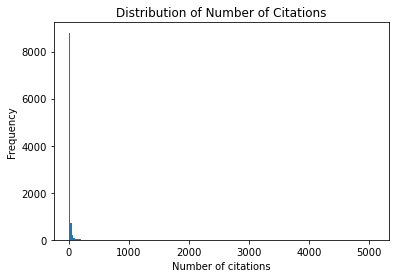

In [68]:
# Plot histogram of result_order
plt.figure()
plt.hist(df['n_citations'], bins=200)
plt.xlabel('Number of citations')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Citations')
plt.show()

In [69]:
df['n_citations'].describe()

count    9921.000000
mean       12.432214
std        58.616713
min         0.000000
25%         1.000000
50%         4.000000
75%        12.000000
max      5072.000000
Name: n_citations, dtype: float64

The number of citations is heavily positively skewed, with 75% of the publication having less than 12 citations and 25% of the articles ranging from 12 to 5072 citations. We may want to remove some outliers.

Attempt to remove the top 5 percentile:

In [70]:
# Set threshold as 95% percentile
citation_threshold = np.percentile(df['n_citations'], 95)
citation_threshold

44.0

95% of publications have citations under 44.

In [71]:
# Filter out the outliers
df_cut = df[df['n_citations']<=citation_threshold]

In [72]:
df_cut.shape

(9429, 17)

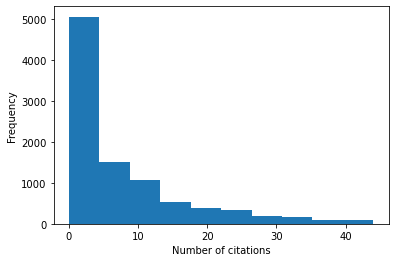

In [73]:
# Plot histogram of result_order
plt.figure()
plt.hist(df_cut['n_citations'], bins=10)
plt.xlabel('Number of citations')
plt.ylabel('Frequency')
plt.show()

Now it is less skewed but the distribution looks almost like logarithmic decay. I could log transform this for a regression model so the distribution resembles a normal distribution. 

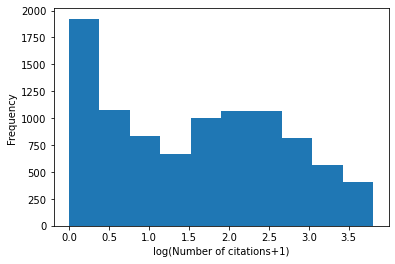

In [74]:
# Plot histogram of result_order
plt.figure()
plt.hist(np.log(df_cut['n_citations']+1), bins=10)
plt.xlabel('log(Number of citations+1)')
plt.ylabel('Frequency')
plt.show()

The distribution now looks bimodal. I am not sure if I can perform a linear regression on this. Besides, about 500 exceptionally well cited publications were removed through this process. Perhaps it's better to bin the target and make this into a classification problem.

Bins:

- Strong: top 95% percentile
- Moderate: top 75% percentile
- Poor (Bad): rest

### Creating classes for classification

In [75]:
# Find threshold for 95% and 75% percentile
perc95 = np.percentile(df['n_citations'], 95)
perc75 = np.percentile(df['n_citations'], 75)

print(perc75, perc95)

12.0 44.0


In [76]:
# Create an 'influence' column based on citation number
df['influence'] = 'bad'
df['influence'] = np.where(df['n_citations']>perc75, 'moderate', df['influence'])
df['influence'] = np.where(df['n_citations']>perc95, 'strong', df['influence'])

df['influence'].value_counts()

bad         7471
moderate    1958
strong       492
Name: influence, dtype: int64

In [77]:
# Export to csv
df.to_csv('pubmedscrape_complete_cleaned2.csv')

Uneven distribution between classes may pose an issue. But let's try.

In [78]:
# Look at the dataframe's info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9921 entries, 0 to 9925
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   article_id        9921 non-null   int64  
 1   title             9921 non-null   object 
 2   publication_type  9921 non-null   object 
 3   abstract          9921 non-null   object 
 4   journal_title     9921 non-null   object 
 5   n_authors         9921 non-null   int64  
 6   affiliations      9921 non-null   object 
 7   n_affiliations    9921 non-null   int64  
 8   n_citations       9921 non-null   int64  
 9   keywords          9921 non-null   object 
 10  n_references      2917 non-null   float64
 11  result_order      9921 non-null   int64  
 12  pub_year          9921 non-null   int64  
 13  n_keywords        9921 non-null   int64  
 14  abstract_wc       9921 non-null   int64  
 15  title_wc          9921 non-null   int64  
 16  n_countries       9921 non-null   int64  


In [79]:
# Look at the distribution of dataframe's numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
article_id,9921.0,2.505242e+07,5.995630e+06,327554.0,21112156.0,25624797.0,30004040.0,34249231.0
n_authors,9921.0,5.274468e+00,4.020658e+00,1.0,2.0,4.0,7.0,55.0
n_affiliations,9921.0,4.229211e+00,5.356135e+00,0.0,1.0,1.0,6.0,88.0
n_citations,9921.0,1.243221e+01,5.861671e+01,0.0,1.0,4.0,12.0,5072.0
n_references,2917.0,6.707268e+01,5.097985e+01,10.0,34.0,51.0,83.0,736.0
result_order,9921.0,4.961000e+03,2.864090e+03,1.0,2481.0,4961.0,7441.0,9921.0
pub_year,9921.0,2.013669e+03,5.669593e+00,1974.0,2010.0,2015.0,2018.0,2021.0
n_keywords,9921.0,3.172664e+01,2.410501e+01,0.0,15.0,30.0,46.0,183.0
abstract_wc,9921.0,1.735859e+02,8.851269e+01,1.0,125.0,182.0,232.0,686.0
title_wc,9921.0,1.270638e+01,5.009665e+00,1.0,9.0,12.0,16.0,48.0


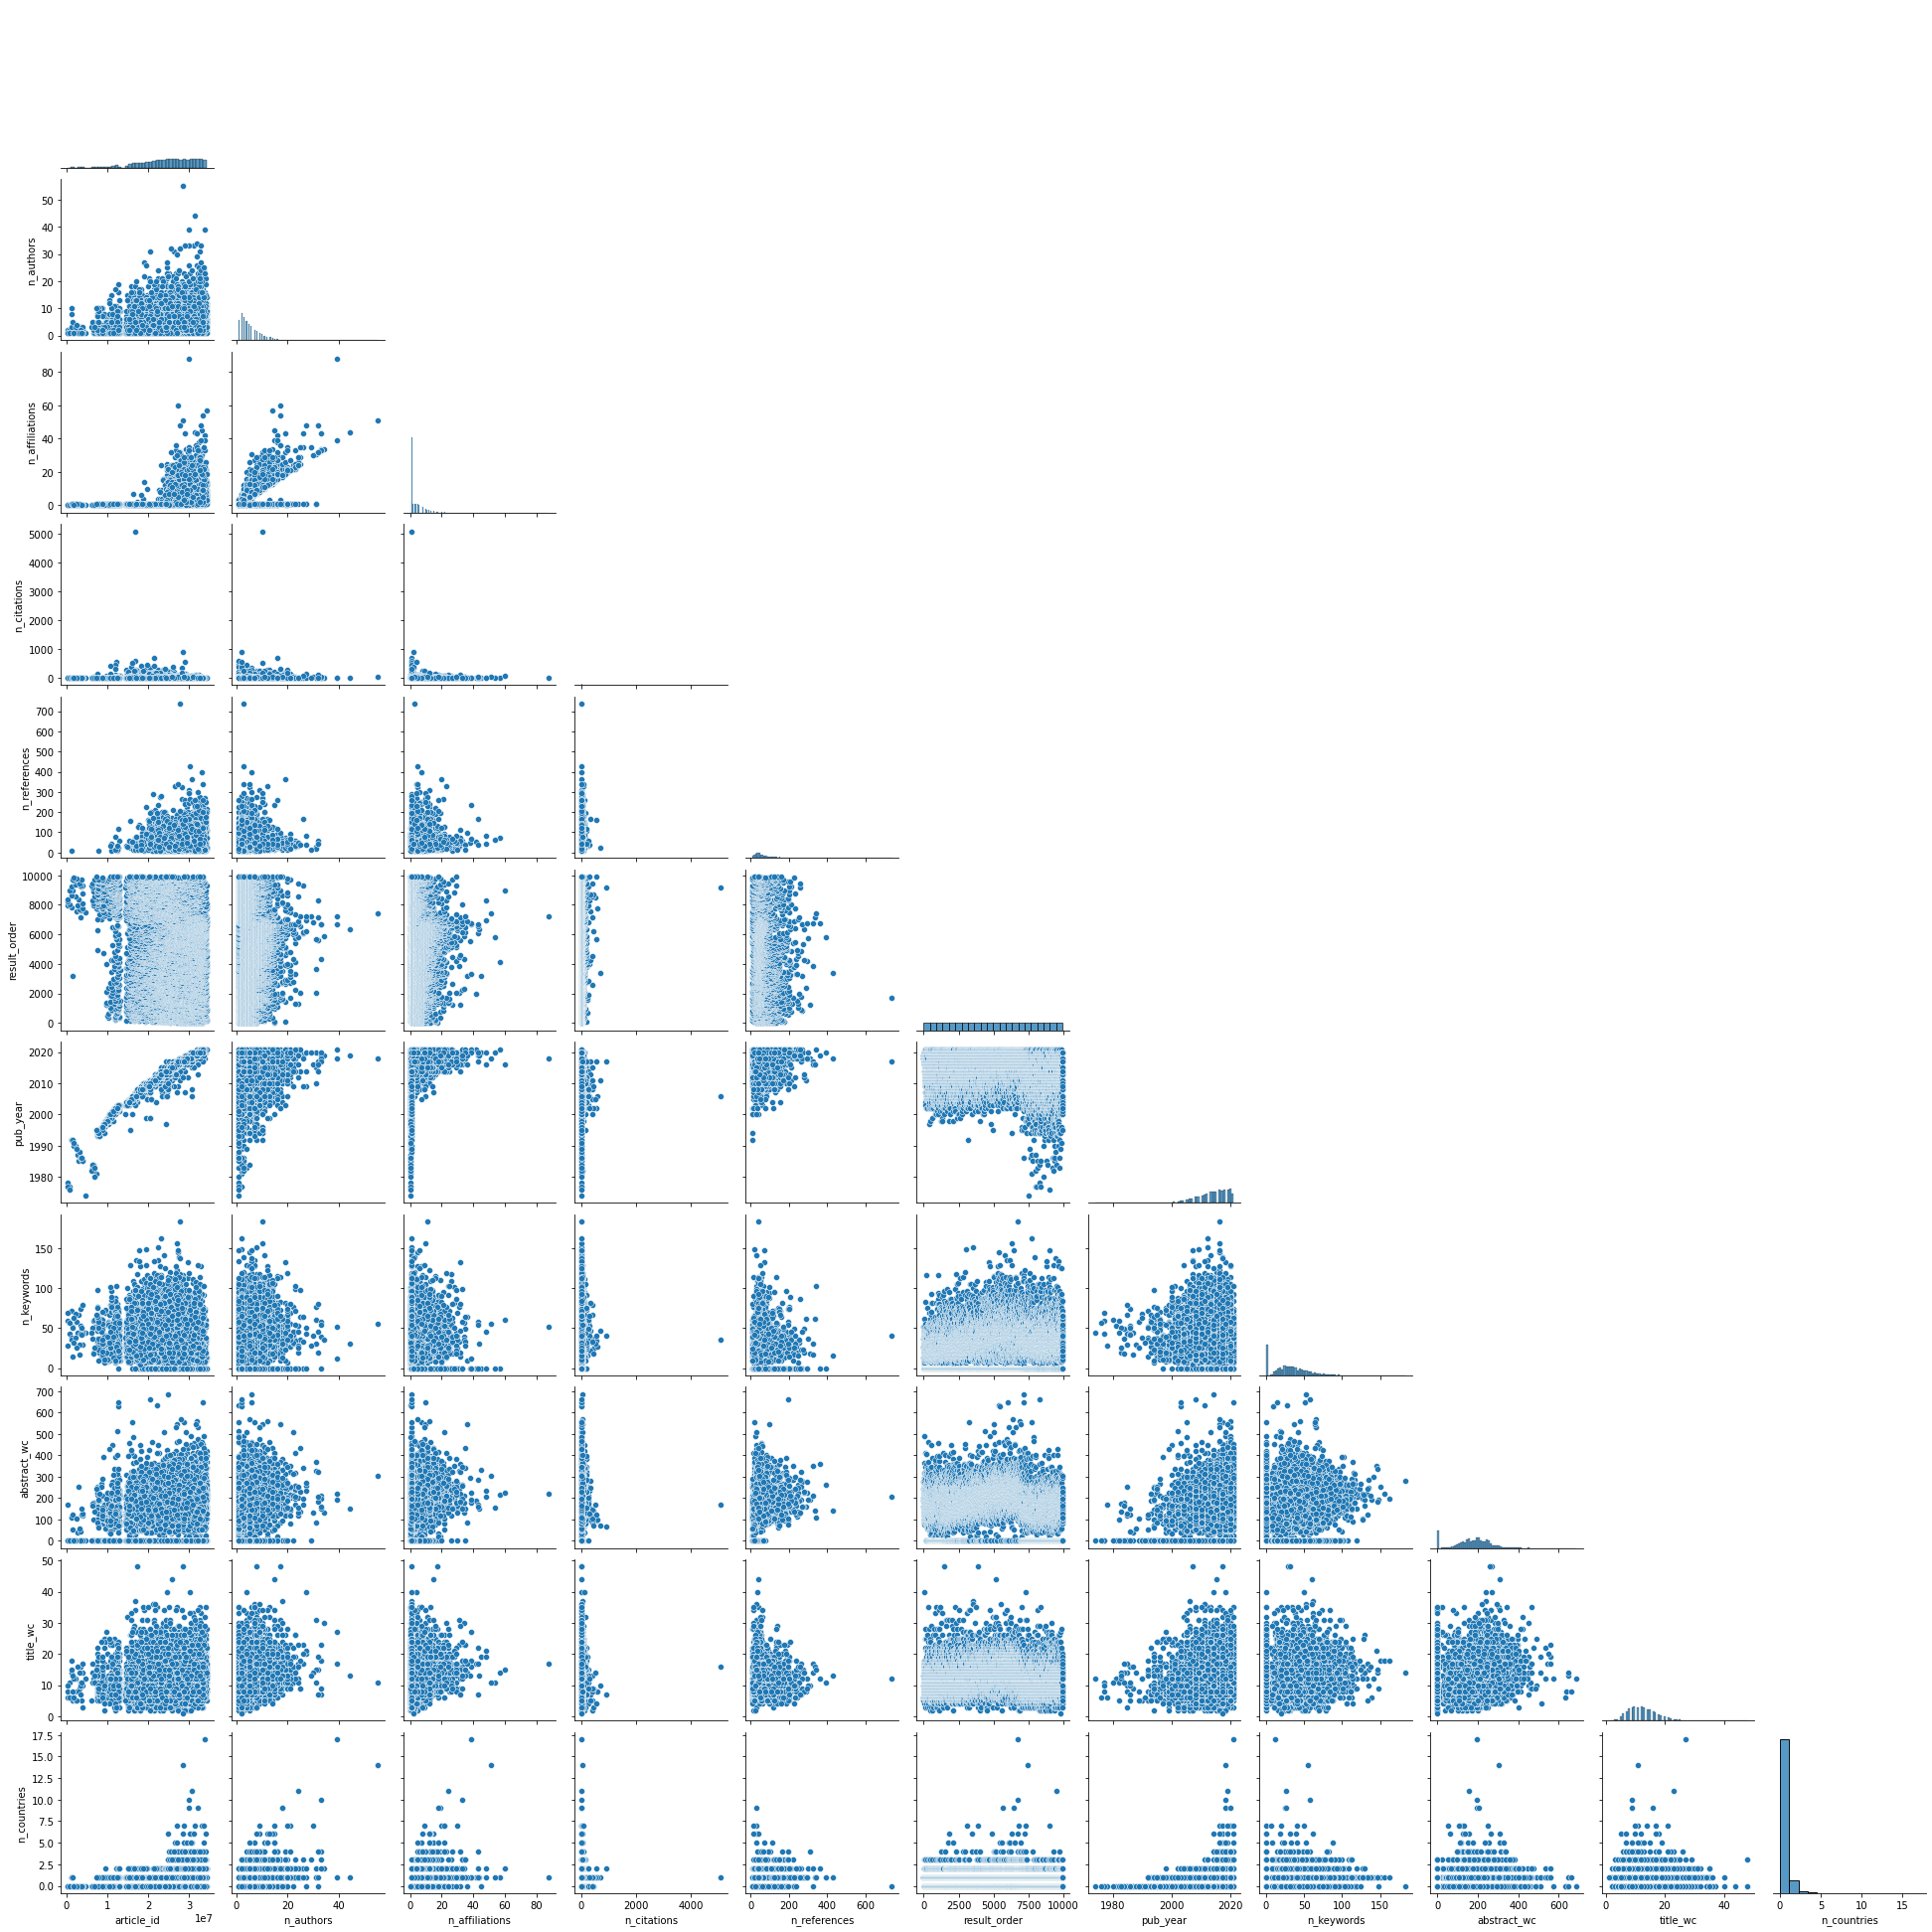

In [80]:
# Look for collinearity in X variables
plt.figure
sns.pairplot(df, corner=True)
plt.show()

Some notable observations:
- Most variables are normally distributed with a slight skew 
- n_citations, n_countries are heavily skewed
- result_order is uniformly distributed
- not many obvious linear relationships, some triangle scatter plots
- result order is uniformly distributed and does not show many obvious correlation with the other variables in this pairplot
- n_citation has an outlier at around 5000 (max is 5063) --> will take a look


Some notable collinearities:
- pub_year and article_id (will drop article_id)
- n_authors and n_affiliations

In [81]:
# Drop article_id
df = df.drop(columns='article_id')

### Removing outlier

In [82]:
# Take a look at the outlier
df[df['n_citations']>=1000]

,title,publication_type,abstract,journal_title,n_authors,affiliations,n_affiliations,n_citations,keywords,n_references,result_order,pub_year,n_keywords,abstract_wc,title_wc,n_countries,influence
9167,minimal criteria for defining multipotent mese...,Review,the considerable therapeutic potential of huma...,Cytotherapy,10,Italy,1,5072,antigens cell culture techniques cell differen...,NaN,9163,2006,36,169,16,1,strong


This paper sets out a criteria for an entire subfield of stem cell therapies. This makes sense that it has so many citations since they have essentially set out a universal rule when using a specific type of stem cell in research. I will drop this outlier for now since no other publication in the search results come close to the number of citations listed here. 

In [83]:
# Let's drop this outlier and reset_index
df = df.drop(df[df['n_citations']>=1000].index, axis=0).reset_index(drop=True)

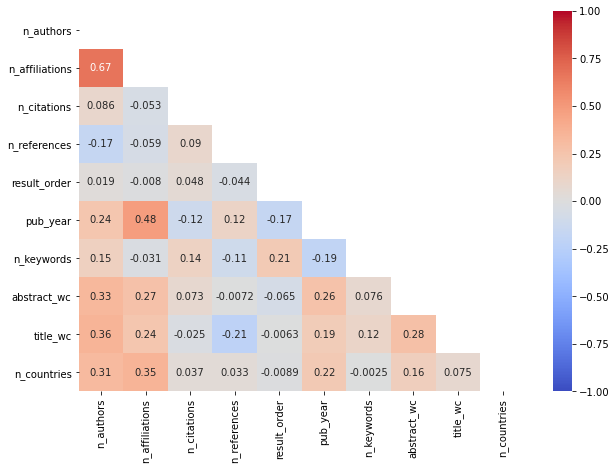

In [84]:
# Get the correlation matrix
corr_mat = df.corr()

# Visualize correlation
plt.figure(figsize=(10,7))
matrix = np.triu(corr_mat)
sns.heatmap(corr_mat, cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, annot=True, mask=matrix)
plt.show()

Observations:
- sadly most variables are weakly correlated with n_citations - this does not look promising for our classification problem
- n_authors is relatively strongly correlated many variables, except with n_references which is negatively correlated and n_citations with little correlation
- interesting to see title_wc has strong-ish relationship with n_authors - is this because it is difficult to get to a consensus with more people working together?
- result_order has a relatively strong correlation with n_keywords and a weak correlation with publication year - looks like older publication are preferentially presented

## Classification Problem:

Find predictors for a publication's 'influence' based on the following features:


- n_authors
- n_affiliations
- publication year
- n_keywords
- abstratct_wc
- title_wc
- n_countries
- affiliations (OHE)
- keywords (Count vectorize)

I will drop abstract and title for now for this problem for simplicity.

### Simple Classification (Only numerical features)

#### Required Flow: 
1. SimpleImpute - n_references
2. Scale
3. Dimension Reduction
4. Classify

#### Define X and y

In [85]:
# Define features and targets
X = df[['n_authors', 'n_affiliations', 'pub_year', 'n_keywords', 
        'abstract_wc', 'title_wc', 'n_countries', 'result_order']]
y = df['influence']

In [86]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=0.3,
      stratify=y)

In [87]:
print('Size of datasets:')
print(f'Train set: {X_train.shape}')
print(f'Test  set: {X_test.shape}')

Size of datasets:
Train set: (6944, 8)
Test  set: (2976, 8)


#### Finding the best model

In [88]:
# Set up a pipeline
estimators = [
     ('impute', SimpleImputer()),
     ('scaling', StandardScaler()),
     ('model', LogisticRegression())]

pipe = Pipeline(estimators)

# Set up gridsearch
params = [{'model':[LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), SVC()],
           'impute':[SimpleImputer(strategy='median')],
           'scaling':[StandardScaler(),RobustScaler(),MinMaxScaler()]}]

grid_search = GridSearchCV(pipe, params, verbose=1)
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [89]:
# See results in dataframe
results = pd.DataFrame({
    'scaler':fitted_search.cv_results_['param_scaling'],
    'model':fitted_search.cv_results_['param_model'],
    'fit_time':fitted_search.cv_results_['mean_fit_time'],
    'mean_test_score':fitted_search.cv_results_['mean_test_score'],
    'std_test_score':fitted_search.cv_results_['std_test_score'],
    'rank_test_score':fitted_search.cv_results_['rank_test_score'],
})

results.sort_values('rank_test_score')

,scaler,model,fit_time,mean_test_score,std_test_score,rank_test_score
9,StandardScaler(),SVC(),1.057620,0.753745,0.002996,1
10,RobustScaler(),SVC(),1.066854,0.753168,0.002834,2
11,MinMaxScaler(),SVC(),1.111038,0.753168,0.000217,3
2,MinMaxScaler(),LogisticRegression(),0.133863,0.752016,0.002323,4
0,StandardScaler(),LogisticRegression(),0.061202,0.751873,0.004350,5
1,RobustScaler(),LogisticRegression(),0.065835,0.751873,0.004350,5
7,RobustScaler(),KNeighborsClassifier(),0.026624,0.736608,0.006474,7
8,MinMaxScaler(),KNeighborsClassifier(),0.019312,0.734016,0.006267,8
6,StandardScaler(),KNeighborsClassifier(),0.022742,0.732432,0.007001,9
4,RobustScaler(),DecisionTreeClassifier(),0.031893,0.652075,0.005104,10


All models but the Decision Tree Classifier (DT) resulted in scores higher than 70%. This makes sense to me because DT models require more hyperparameter tuning since it is prone to overfitting.

Support Vector Machine (SVC) with StandardScaler() resulted in the highest mean validation score of 75.4%. However, the Logistic Regression model was not far behind with a score of 75.2%. 

Fit times were fastest for KNN and DT models, closely followed by Logistic Regression. SVC fit time was about 10-fold higher than that of Logistic Regression models. 

From these results, my current preference is the simple Logistic Regression model, especially with the simple interpretability. Let's perform some hyperparameter tuning to see if we can improve these scores.

Note: DT models are not affected by scaling so the difference in scores can be attributed to the inherent randomness of the algorithm (stability is also another added bonus of the Logistic Regression model, we will always come to the same accuracy with the same inputs).

#### Hyperparameter Tuning

In [123]:
# Set up a pipeline
estimators = [
     ('impute', SimpleImputer()),
     ('scaling', StandardScaler()),
     ('model', LogisticRegression())]

pipe = Pipeline(estimators)

# Set up gridsearch
params = [{'model':[LogisticRegression(penalty='l1', solver='liblinear')],
           'impute':[SimpleImputer(strategy='median')],
           'scaling':[StandardScaler()],
           'model__C':[0.0001, 1, 10, 1000]}, 
          {'model':[LogisticRegression(penalty='l2', solver='lbfgs')],
           'impute':[SimpleImputer(strategy='median')],
           'scaling':[StandardScaler()],
           'model__C':[0.0001, 1, 10, 1000]},
          {'model':[SVC()],
           'impute':[SimpleImputer(strategy='median')],
           'scaling':[StandardScaler()]},
          {'model':[DecisionTreeClassifier()],
           'impute':[SimpleImputer(strategy='median')],
           'model__max_depth':[1, 2, 3, 5, 20]}]

grid_search = GridSearchCV(pipe, params, verbose=1)
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipelin

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipelin

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipelin

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\pipelin

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Review'

In [91]:
# See results in dataframe
results_num = pd.DataFrame({
    'model':fitted_search.cv_results_['param_model'],
    'C':fitted_search.cv_results_['param_model__C'],
    'max_depth':fitted_search.cv_results_['param_model__max_depth'],
    'fit_time':fitted_search.cv_results_['mean_fit_time'],
    'mean_test_score':fitted_search.cv_results_['mean_test_score'],
    'std_test_score':fitted_search.cv_results_['std_test_score'],
    'rank_test_score':fitted_search.cv_results_['rank_test_score'],
})
    
results_num.sort_values('rank_test_score')

,model,C,max_depth,fit_time,mean_test_score,std_test_score,rank_test_score
8,SVC(),NaN,NaN,1.049372,0.753745,0.002996,1
0,"LogisticRegression(penalty='l1', solver='libli...",0.0001,NaN,0.015849,0.753168,0.000217,2
4,LogisticRegression(),0.0001,NaN,0.042711,0.753168,0.000217,2
9,DecisionTreeClassifier(),NaN,1,0.012406,0.753168,0.000217,2
10,DecisionTreeClassifier(),NaN,2,0.012415,0.753168,0.000217,2
11,DecisionTreeClassifier(),NaN,3,0.012341,0.752736,0.000330,6
5,LogisticRegression(),1,NaN,0.044572,0.751873,0.004350,7
1,"LogisticRegression(penalty='l1', solver='libli...",1,NaN,0.029542,0.751873,0.004060,8
2,"LogisticRegression(penalty='l1', solver='libli...",10,NaN,0.025320,0.751873,0.004060,8
3,"LogisticRegression(penalty='l1', solver='libli...",1000,NaN,0.022497,0.751873,0.004060,8


With hyperparameter tuning, we were able to inch quite close to the best SVC() model using Logistic Regression. Let's try to understand how each feature is impacting the odds ratio of the classification.

#### Try best logistic regression model

In [92]:
# Split data further into train and val
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train)

In [93]:
# Fit to best logreg model
# Impute n_references
imp = SimpleImputer(strategy='most_frequent')
X_train_vals = imp.fit_transform(X_train_)
X_val_vals = imp.transform(X_val)

X_train_ = pd.DataFrame(X_train_vals, columns=X_train_.columns)
X_val = pd.DataFrame(X_val_vals, columns=X_train_.columns)
# Fit scaler to training set
scaler = StandardScaler()
scaler.fit(X_train_)
# Scale training and test sets
X_train_scaled = scaler.transform(X_train_)
X_val_scaled = scaler.transform(X_val)

# Fit model to training set
logreg = LogisticRegression(C=0.0001)
logreg.fit(X_train_scaled, y_train_)

# Score model
print(f'Score on train: {logreg.score(X_train_scaled, y_train_)}')
print(f'Score on validation: {logreg.score(X_val_scaled, y_val)}')

Score on train: 0.7531953195319532
Score on validation: 0.7530597552195825


In [94]:
# Understand coefficients and odds ratio
features = X_train_.columns
bad_coefs = logreg.coef_[0]
moderate_coefs = logreg.coef_[1]
strong_coefs = logreg.coef_[2]

bad_res = pd.DataFrame({'features':features,
                        'coeffs':bad_coefs,
                        'odds_ratio': np.exp(bad_coefs).round(3),})

moderate_res = pd.DataFrame({'features':features,
                             'coeffs':moderate_coefs,
                             'odds_ratio': np.exp(moderate_coefs).round(3)})

strong_res = pd.DataFrame({'features':features,
                           'coeffs':strong_coefs,
                           'odds_ratio': np.exp(strong_coefs).round(3)})

In [95]:
# Top predictors for bad
bad_res.sort_values('odds_ratio', ascending=False)

,features,coeffs,odds_ratio
2,pub_year,0.026506,1.027
1,n_affiliations,0.011884,1.012
5,title_wc,-0.000148,1.000
6,n_countries,-0.007800,0.992
7,result_order,-0.007742,0.992
0,n_authors,-0.023582,0.977
4,abstract_wc,-0.032254,0.968
3,n_keywords,-0.037892,0.963


In [96]:
# Top predictors for moderate
moderate_res.sort_values('odds_ratio', ascending=False)

,features,coeffs,odds_ratio
3,n_keywords,0.025634,1.026
4,abstract_wc,0.026116,1.026
0,n_authors,0.014776,1.015
6,n_countries,0.003960,1.004
7,result_order,0.003814,1.004
5,title_wc,0.001624,1.002
1,n_affiliations,-0.007164,0.993
2,pub_year,-0.015199,0.985


In [97]:
# Top predictors for strong
strong_res.sort_values('odds_ratio', ascending=False)

,features,coeffs,odds_ratio
3,n_keywords,0.012258,1.012
0,n_authors,0.008805,1.009
4,abstract_wc,0.006138,1.006
6,n_countries,0.003841,1.004
7,result_order,0.003928,1.004
5,title_wc,-0.001476,0.999
1,n_affiliations,-0.004720,0.995
2,pub_year,-0.011307,0.989


It looks like all of the coefficients are only moving the needle by a very small percentage points. But in general here are some observations based on the odds ratios:
- Poor influencers tend to be published later, with more affiliations, and longer titles.
- Moderate and strong influencers tend to have more keywords, longer abstracts, and more authors.

Now to evaluate this model, let's take a look at the confusion matrix to understand how well the model is classifying the publications.

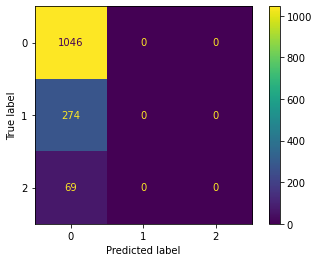

In [98]:
# Confusion Matrix

# Get class predictions
y_pred = logreg.predict(X_val_scaled)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [99]:
# Classification report
report_initial = classification_report(y_val, y_pred)
print(report_initial)

              precision    recall  f1-score   support

         bad       0.75      1.00      0.86      1046
    moderate       0.00      0.00      0.00       274
      strong       0.00      0.00      0.00        69

    accuracy                           0.75      1389
   macro avg       0.25      0.33      0.29      1389
weighted avg       0.57      0.75      0.65      1389



C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looking at the confusion matrix, we can see that this model is a bad classifier, the precision and recall for moderate and strong classes are 0! There is no valid prediction happening because all of the validation samples are being classified as moderate. This means that this model does not perform any better than a base case scenario where we guess that every publication will be poorly influential. It looks like numeric features alone are not enough to predict the 'influence' of a publication. So let's add a few more features.

### Simple Classification (With categorical features)

#### Required Flow: 

1. Define numeric and categorical columns
2. Set up preprocessing pipeline for numeric: `SimpleImputer`, `StandardScaler`
3. Set up preprocessing pipeline for categorical: `OneHotEncoder`
4. Set up preprocessor: `ColumnTransformer`
5. Set up grid search pipeline: `preprocessor`, `model`

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             9920 non-null   object 
 1   publication_type  9920 non-null   object 
 2   abstract          9920 non-null   object 
 3   journal_title     9920 non-null   object 
 4   n_authors         9920 non-null   int64  
 5   affiliations      9920 non-null   object 
 6   n_affiliations    9920 non-null   int64  
 7   n_citations       9920 non-null   int64  
 8   keywords          9920 non-null   object 
 9   n_references      2917 non-null   float64
 10  result_order      9920 non-null   int64  
 11  pub_year          9920 non-null   int64  
 12  n_keywords        9920 non-null   int64  
 13  abstract_wc       9920 non-null   int64  
 14  title_wc          9920 non-null   int64  
 15  n_countries       9920 non-null   int64  
 16  influence         9920 non-null   object 


#### Define X and y

In [101]:
# Define X and y
X = df.drop(columns=['abstract', 'title', 'influence', 'n_citations'])
y = df['influence']

# Make sure split is same as before
train_idx = X_train.index
test_idx = X_test.index

# Split into the same train and test sets
X_train = X.iloc[train_idx, :]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx]

In [102]:
X_train.head()

,publication_type,journal_title,n_authors,affiliations,n_affiliations,keywords,n_references,result_order,pub_year,n_keywords,abstract_wc,title_wc,n_countries
2486,Review,Biomaterials,11,USA,11,animals ferrous compounds chemistry humans me...,NaN,2487,2018,34,145,15,1
8700,Review,Nature clinical practice. Cardiovascular medicine,1,USA,1,cell lineage cell movement cell survival clini...,NaN,8701,2006,32,247,9,1
82,Review,Journal of stroke,4,Unknown,7,none,113.0,83,2016,0,144,9,0
542,Review,Canadian journal of physiology and pharmacology,4,USA,8,angiogenesis inducing agents therapeutic use ...,NaN,543,2017,82,180,16,1
7794,Editorial,Regenerative medicine,2,Unknown,0,cell cell embryonic stem cells cytology europ...,NaN,7795,2011,25,1,9,0


#### Set up pipeline

In [103]:
# Define numeric features
num_cols = ['n_authors', 'n_affiliations',
            'n_references', 'result_order', 'pub_year',
            'n_keywords', 'abstract_wc', 'title_wc', 'n_countries']

cat_cols = ['affiliations', 'journal_title', 'publication_type', 'keywords']

# Set up preprocessing pipeline for each col type
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

cat_transformer = Pipeline([('ohe',OneHotEncoder(handle_unknown='ignore'))])

# Combine pipes 
preprocessor = ColumnTransformer(transformers= [('num', num_transformer, num_cols),
                                                ('cat', cat_transformer, cat_cols)])

# Append model to preprocessing pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('model', LogisticRegression())])

# Set up gridsearch
params = [{'model':[LogisticRegression(penalty='l1', solver='liblinear')],
           'preprocessor':[preprocessor],
           'model__C':[0.0001, 1, 10, 1000]}, 
          {'model':[LogisticRegression(penalty='l2', solver='lbfgs')],
           'preprocessor':[preprocessor],
           'model__C':[0.0001, 1, 10, 1000]},
          {'model':[SVC()],
           'preprocessor':[preprocessor]}]

grid_search = GridSearchCV(pipe, params, verbose=1)
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

#### Results

In [104]:
# See results in dataframe
results = pd.DataFrame({
    'model':fitted_search.cv_results_['param_model'],
    'C':fitted_search.cv_results_['param_model__C'],
    'fit_time':fitted_search.cv_results_['mean_fit_time'],
    'mean_test_score':fitted_search.cv_results_['mean_test_score'],
    'rank_test_score':fitted_search.cv_results_['rank_test_score'],
})

results.sort_values('rank_test_score')

,model,C,fit_time,mean_test_score,rank_test_score
5,LogisticRegression(C=1),1,0.473895,0.758641,1
1,"LogisticRegression(penalty='l1', solver='libli...",1,0.208952,0.757489,2
8,SVC(),NaN,1.202404,0.757201,3
2,"LogisticRegression(penalty='l1', solver='libli...",10,0.649102,0.754320,4
6,LogisticRegression(C=1),10,0.442191,0.753744,5
0,"LogisticRegression(penalty='l1', solver='libli...",0.0001,0.049404,0.753168,6
4,LogisticRegression(C=1),0.0001,0.338079,0.753168,6
7,LogisticRegression(C=1),1000,0.440692,0.742655,8
3,"LogisticRegression(penalty='l1', solver='libli...",1000,0.460604,0.738911,9


In [105]:
results_num.sort_values('rank_test_score').head(3)

,model,C,max_depth,fit_time,mean_test_score,std_test_score,rank_test_score
8,SVC(),NaN,NaN,1.049372,0.753745,0.002996,1
0,"LogisticRegression(penalty='l1', solver='libli...",0.0001,NaN,0.015849,0.753168,0.000217,2
4,LogisticRegression(),0.0001,NaN,0.042711,0.753168,0.000217,2


With one hot encoding of the categorical columns, the best performing model is Logistic Regression with l2 penalty and C=1 at 75.9%. We are seeing a ~0.5% improvement from our previous logistic regression model.

#### Try the best logistic regression model

In [125]:
# Split data further into train and val
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train)

In [126]:
X.columns

Index(['publication_type', 'journal_title', 'n_authors', 'affiliations',
       'n_affiliations', 'keywords', 'n_references', 'result_order',
       'pub_year', 'n_keywords', 'abstract_wc', 'title_wc', 'n_countries'],
      dtype='object')

In [127]:
# Logistic Regression

# Define logreg pipeline
logreg_pipe = Pipeline([('preprocessor', preprocessor),
                        ('model', LogisticRegression(C=1))])

# Fit pipeline to training set
logreg_pipe.fit(X_train_, y_train_)

# Score model
print(f'Score on train: {logreg_pipe.score(X_train_, y_train_)}')
print(f'Score on validation: {logreg_pipe.score(X_val, y_val)}')

Score on train: 0.9062106210621063
Score on validation: 0.7645788336933045


C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [128]:
# Fit OHE columns into original columns
# Original columns
orig = X_train.columns

# Find index number for categorical columns
pubtype_idx = np.where(orig=='publication_type')[0][0]
aff_idx = np.where(orig=='affiliations')[0][0]
journal_idx = np.where(orig=='journal_title')[0][0]
kw_idx = np.where(orig=='keywords')[0][0]

# OHE features
ohe_features = logreg_pipe.steps[0][1].named_transformers_['cat'].steps[0][1].get_feature_names()

# Find encoded features
pubtype = [x for x in ohe_features if 'x2_' in x]
affs = [x for x in ohe_features if 'x0_' in x]
journal = [x for x in ohe_features if 'x1_' in x]
kw = [x for x in ohe_features if 'x3_' in x]

In [129]:
ohe_features

array(['x0_Albania', 'x0_Algeria', 'x0_Argentina', ...,
       'x3_humans stem cell transplantation urinary bladder diseases  surgery',
       'x3_mesenchymal stem cells  cytology mesenchymal stem cells  physiology multipotent stem cells  cytology multipotent stem cells  physiology stromal cells  cytology stromal cells  physiology inology as topic',
       'x3_none'], dtype=object)

Looking at the OHE features, I see that the keywords column cannot just simply be one hot encoded but must vectorized for any meaningful analysis. Nonetheless let's keep going for now.

In [130]:
# Create new list for encoded features
encoded_idx = []
for idx in orig:
    if idx == orig[pubtype_idx]:
        for p in pubtype:
            encoded_idx.append(p)
    elif idx == orig[aff_idx]:
        for a in affs:
            encoded_idx.append(a)
    elif idx == orig[journal_idx]:
        for j in journal:
            encoded_idx.append(j)
    elif idx == orig[kw_idx]:
        for k in kw:
            encoded_idx.append(k)
    else: encoded_idx.append(idx)

In [131]:
logreg_pipe.steps[1][1].classes_

array(['bad', 'moderate', 'strong'], dtype=object)

In [132]:
# Display results in dataframe
features = encoded_idx
coeff_bad = logreg_pipe.steps[1][1].coef_[0]
coeff_moderate = logreg_pipe.steps[1][1].coef_[1]
coeff_strong = logreg_pipe.steps[1][1].coef_[2]

bad_res = pd.DataFrame({'features':features,
                        'coeffs':coeff_bad,
                        'odds_ratio': np.exp(coeff_bad).round(3),})

moderate_res = pd.DataFrame({'features':features,
                             'coeffs':coeff_moderate,
                             'odds_ratio': np.exp(coeff_moderate).round(3)})

strong_res = pd.DataFrame({'features':features,
                           'coeffs':coeff_strong,
                           'odds_ratio': np.exp(coeff_strong).round(3)})

In [133]:
# Top predictors for bad
bad_res.sort_values('odds_ratio', ascending=False).head(10)

,features,coeffs,odds_ratio
1911,x3_3 adult base sequence carcinoma carcinoma c...,1.164354,3.204
1673,x1_The journal of gene medicine,0.909371,2.483
457,"x1_Clinical science (London, England : 1979)",0.873987,2.396
1902,x0_Venezuela,0.853131,2.347
1291,x1_Nature reviews. Gastroenterology & hepatology,0.808442,2.244
1523,"x1_Science (New York, N.Y.)",0.799431,2.224
592,x1_Digestion,0.794714,2.214
1287,x1_Nature reviews. Cardiology,0.747872,2.113
2520,x3_adult aged blood cell count blood cells im...,0.719300,2.053
482,x1_Coronary artery disease,0.701169,2.016


In [134]:
# Top predictors for moderate
moderate_res.sort_values('odds_ratio', ascending=False).head(10)

,features,coeffs,odds_ratio
1431,x1_Physical medicine and rehabilitation clinic...,1.137727,3.120
1631,x1_The Journal of investigative dermatology,0.992604,2.698
1527,x1_Scientific reports,0.985746,2.680
1040,x1_Journal of interventional cardiac electroph...,0.964448,2.623
208,x1_BMC veterinary research,0.963735,2.621
1097,"x1_Journal of physiology, Paris",0.925009,2.522
532,x1_Current opinion in ophthalmology,0.901950,2.464
215,x1_Basic & clinical pharmacology & toxicology,0.896198,2.450
307,x1_Briefings in bioinformatics,0.877480,2.405
132,x1_Annals of anatomy = Anatomischer Anzeiger :...,0.855357,2.352


In [135]:
# Top predictors for strong
strong_res.sort_values('odds_ratio', ascending=False).head(10)

,features,coeffs,odds_ratio
1728,x1_Translational vision science & technology,1.527923,4.609
1519,x1_Scandinavian journal of clinical and labora...,1.434254,4.197
1185,x1_Liver international : official journal of t...,1.402164,4.064
454,x1_Clinical pharmacology and therapeutics,1.337264,3.809
432,x1_Clinical and experimental immunology,1.333795,3.795
488,x1_Critical reviews in immunology,1.326790,3.769
449,"x1_Clinical lymphoma, myeloma & leukemia",1.244893,3.473
1246,x1_Molecular pharmaceutics,1.218170,3.381
1592,x1_The Analyst,1.202754,3.329
486,x1_Critical reviews in clinical laboratory sci...,1.195902,3.307


Based on the above analysis, it looks like the journal (x1 variables) are the key determinants of the number of citations. This makes sense since with the vast amount of publications published around a specific topic, the reputation of journals tend to be the first determinant for whether to include one into the reading list. Let's take a look at the Confusion Matrix.

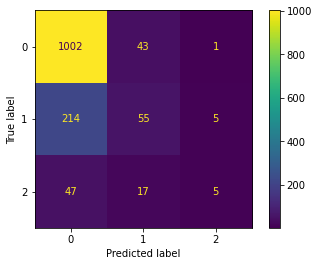

In [137]:
# Confusion Matrix

# Get class predictions
y_pred = logreg_pipe.predict(X_val)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [138]:
# Classification report
report_initial = classification_report(y_val, y_pred)
print(report_initial)

              precision    recall  f1-score   support

         bad       0.79      0.96      0.87      1046
    moderate       0.48      0.20      0.28       274
      strong       0.45      0.07      0.12        69

    accuracy                           0.76      1389
   macro avg       0.58      0.41      0.43      1389
weighted avg       0.71      0.76      0.72      1389



Looking at the confusion matrix we see a marked increase with this model in terms of precision and recall in the moderate and strong classes. The recall score is still quite poor for both classes as most publications are still being classified as poor.

### Simple Classification (With vectorized keywords)

Lastly I want to see if we can improve this model by vectorizing the keywords. I could not find a way to incorporate this into a pipe so I will perform a logistic regression model on the entire dataset (minus the test set).

In [119]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [120]:
# Split into X, y and re-index
X_train_1 = X_train_.reset_index(drop='first')
X_val1 = X_val.reset_index(drop='first')
y_train_1 = y_train_.reset_index(drop='first')
y_val1 = y_val.reset_index(drop='first')

In [121]:
# create tokenizer with stemming
stemmer = nltk.stem.PorterStemmer()
tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')]

# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=5,
                        max_df=0.95,
                        max_features=100,
                        tokenizer=tokenizer)

In [146]:
# Get keywords and vectorized_kw
vectorized_kw = tfidf.fit_transform(X_train_1['keywords']).toarray()
vectorized_kw_val = tfidf.transform(X_val1['keywords']).toarray()

# Create dataframe
kw_df = pd.DataFrame(vectorized_kw, columns=tfidf.get_feature_names())
kw_val_df = pd.DataFrame(vectorized_kw_val, columns=tfidf.get_feature_names())

In [147]:
# Concatenate vectorized keywords to X_train_ and X_val
X_train_1 = pd.concat([X_train_1, kw_df], axis=1).drop('keywords', axis=1)
X_val1 = pd.concat([X_val1, kw_val_df], axis=1).drop('keywords', axis=1)

In [148]:
# One Hot Encode categorical columns

cat_cols = ['affiliations', 'journal_title', 'publication_type']

for col in cat_cols:

    # One Hot Encode other categorical variables
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe_ = ohe.fit(X_train_1[col].values.reshape(-1,1))
    ohe_train_trans = ohe_.transform(X_train_1[col].values.reshape(-1,1))
    ohe_val_trans = ohe_.transform(X_val1[col].values.reshape(-1,1))

    # Create Dataframes
    ohe_train_trans_df = pd.DataFrame(ohe_train_trans.toarray(), columns=ohe_.categories_[0])
    ohe_val_trans_df = pd.DataFrame(ohe_val_trans.toarray(), columns=ohe_.categories_[0])

    # Add into dataset
    X_train_1 = pd.concat([X_train_1, ohe_train_trans_df], axis=1).drop(col, axis=1)
    X_val1 = pd.concat([X_val1, ohe_val_trans_df], axis=1).drop(col, axis=1)

In [149]:
# Impute n_references
imp = SimpleImputer(strategy='most_frequent')

X_train_vals = imp.fit_transform(X_train_1)
X_val_vals = imp.transform(X_val1)

X_train_1 = pd.DataFrame(X_train_vals, columns=X_train_1.columns)
X_val1 = pd.DataFrame(X_val_vals, columns=X_train_1.columns)

In [150]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train_1)
# Scale training and test sets
X_train_scaled = scaler.transform(X_train_1)
X_val_scaled = scaler.transform(X_val1)

C= 1e-05 done
C= 0.0001 done
C= 1 done
C= 10 done


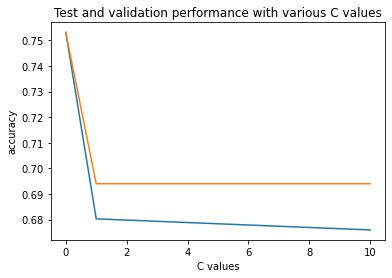

In [151]:
# Create empty lists to store accuracies
train_accs = []
val_accs = []
C_values = [0.00001, 0.0001, 1, 10]

for C in C_values:
    # Fit model to train data
    logreg = LogisticRegression(penalty='l1', 
                                C=C, 
                                solver='liblinear')
    logreg.fit(X_train_scaled, y_train_)
    
    # Score on train and val data
    train_acc = logreg.score(X_train_scaled, y_train_1)
    val_acc = logreg.score(X_val_scaled, y_val1)
    
    # Append info to lists
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print('C=', C, 'done')
    
# Plot the scores against the C values
plt.figure()
plt.plot(C_values, train_accs, label='train')
plt.plot(C_values, val_accs, label='validation')
plt.ylabel('accuracy')
plt.xlabel('C values')
plt.title('Test and validation performance with various C values')
plt.show()

In [152]:
# Fit model to training set
logreg1 = LogisticRegression(penalty='l1',
                            C=0.0001,
                            solver='liblinear')
logreg1.fit(X_train_scaled, y_train_)

# Score model
print(f'Score on train: {logreg.score(X_train_scaled, y_train_)}')
print(f'Score on validation: {logreg.score(X_val_scaled, y_val)}')

Score on train: 0.8318631863186319
Score on validation: 0.6969042476601872


With vectorization of the keywords, the model actually decreased in performance. I also see that there is a case of overfitting as the score on the training set has improved.

## Summary


I fitted a classification model on the scraped PubMed data to predict an article's `influence` in terms of the number of citations it has. Initial EDA showed that citations were heavily positively skewed. I removed one anomaly from the dataset and binned the number of citations in terms of 'bad', 'moderate', and 'strong'. The distribution was still skewed towards the 'bad' bin. There are a couple of reasons why this may be. Firstly, in academia, it is really difficult to publish a paper that is well cited. Secondly, about 20% of the initial data was missing citation information and 0 was imputed in its place. 


In terms of the model, I started with a simple classification using only the numerical features, one hot encoded the categorical features, and finally vectorized the keywords. The best model was the Logistic Regression model with the numerical features plus one hot encoded categorical features with an accuracy rate of 76.5% on the validation set. 


The precision and especially recall scores were low for 'moderate' and 'strong' classes. This is most likely due to the fact that the data is heavily skewed towards the 'bad' influencers, and the fact that the sample size for the other two bins were quite small. One solution to this is to collect more data for the better influencers. Another option is to bin the log-transformed number of citations and create more even bins in terms of number of publications. 


From the count vectorization of keywords, I saw that there was some over-fitting and improvement in the training accuracy. This gives me a hunch that certain topics may have more or less citations than others. Specific subtopics within 'stem cell therapies' may be more prevalent. This leads me to think that a more meaningful analysis for this dataset is Topic Modeling. From 9200+ papers will I be able to condense the subtopics of 'stem cell therapies' down to ~10-100 topics? How do these topics differ in terms of number of citations? 